# Gap junction-coupled FitzHugh-Nagumo Model

In [1]:
import brainpy as bp
import brainpy.math as bm

bp.math.enable_x64()
bp.math.set_platform('cpu')

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class GJCoupledFHN(bp.dyn.DynamicalSystem):
  def __init__(self, num=2, method='exp_auto'):
    super(GJCoupledFHN, self).__init__()

    # parameters
    self.num = num
    self.a = 0.7
    self.b = 0.8
    self.tau = 12.5
    self.gjw = 0.0001

    # variables
    self.V = bm.Variable(bm.random.uniform(-2, 2, num))
    self.w = bm.Variable(bm.random.uniform(-2, 2, num))
    self.Iext = bm.Variable(bm.zeros(num))

    # functions
    self.int_V = bp.odeint(self.dV, method=method)
    self.int_w = bp.odeint(self.dw, method=method)

  def dV(self, V, t, w, Iext=0.):
    gj = (V.reshape((-1, 1)) - V).sum(axis=0) * self.gjw
    dV = V - V * V * V / 3 - w + Iext + gj
    return dV

  def dw(self, w, t, V):
    dw = (V + self.a - self.b * w) / self.tau
    return dw

  def update(self, _t, _dt):
    self.V.value = self.int_V(self.V, _t, self.w, self.Iext, _dt)
    self.w.value = self.int_w(self.w, _t, self.V, _dt)
    
  def step(self, vw):
    v, w = bm.split(vw, 2)
    dv = self.dV(v, 0., w, self.Iext)
    dw = self.dw(w, 0., v)
    return bm.concatenate([dv, dw])  

In [18]:
def analyze_net(num=2, gjw=0.01, Iext=bm.asarray([0., 0.6])):
    assert isinstance(Iext, (int, float)) or (len(Iext) == num)
    
    model = GJCoupledFHN(num)
    model.gjw = gjw
    model.Iext[:] = Iext
    
    # simulation
    runner = bp.dyn.DSRunner(model, monitors=['V'])
    runner.run(300.)
    bp.visualize.line_plot(runner.mon.ts, runner.mon.V, legend='V',
                           plot_ids=list(range(model.num)), show=True)

    # analysis
    finder = bp.analysis.SlowPointFinder(f_cell=model.step)
    finder.find_fps_with_gd_method(
      candidates=bm.random.normal(0., 2., (1000, model.num * 2)),
      tolerance=1e-5, num_batch=200,
        optimizer=bp.optim.Adam(lr=bp.optim.ExponentialDecay(0.05, 1, 0.9999)),
    )
    finder.filter_loss(1e-7)
    finder.keep_unique()

    print('fixed_points: ', finder.fixed_points)
    print('losses:', finder.losses)
    if len(finder.fixed_points):
      jac = finder.compute_jacobians(finder.fixed_points)
      for i in range(len(finder.fixed_points)):
        eigval, eigvec = np.linalg.eig(np.asarray(jac[i]))
        plt.figure()
        plt.scatter(np.real(eigval), np.imag(eigval))
        plt.plot([0, 0], [-1, 1], '--')
        plt.xlabel('Real')
        plt.ylabel('Imaginary')
        plt.title(f'FP {i}')
        plt.show()

## 4D system

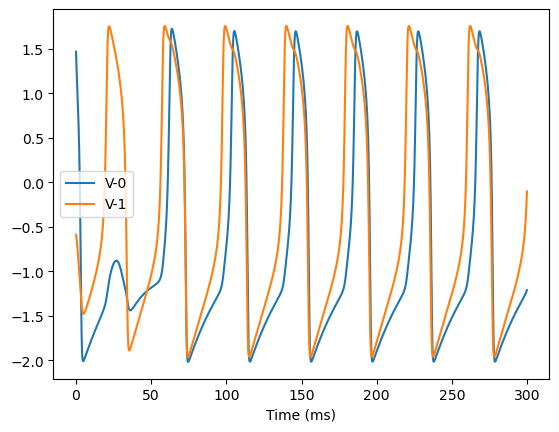

Optimizing to find fixed points:
    Batches 1-200 in 0.26 sec, Training loss 0.1732008333
    Batches 201-400 in 0.27 sec, Training loss 0.0279936077
    Batches 401-600 in 0.29 sec, Training loss 0.0138208361
    Batches 601-800 in 0.27 sec, Training loss 0.0106248316
    Batches 801-1000 in 0.26 sec, Training loss 0.0091556911
    Batches 1001-1200 in 0.26 sec, Training loss 0.0081304573
    Batches 1201-1400 in 0.27 sec, Training loss 0.0073151766
    Batches 1401-1600 in 0.27 sec, Training loss 0.0066392938
    Batches 1601-1800 in 0.26 sec, Training loss 0.0060650256
    Batches 1801-2000 in 0.26 sec, Training loss 0.0055699468
    Batches 2001-2200 in 0.33 sec, Training loss 0.0051349353
    Batches 2201-2400 in 0.26 sec, Training loss 0.0047495742
    Batches 2401-2600 in 0.27 sec, Training loss 0.0044025139
    Batches 2601-2800 in 0.26 sec, Training loss 0.0040867868
    Batches 2801-3000 in 0.28 sec, Training loss 0.0037980253
    Batches 3001-3200 in 0.26 sec, Training loss

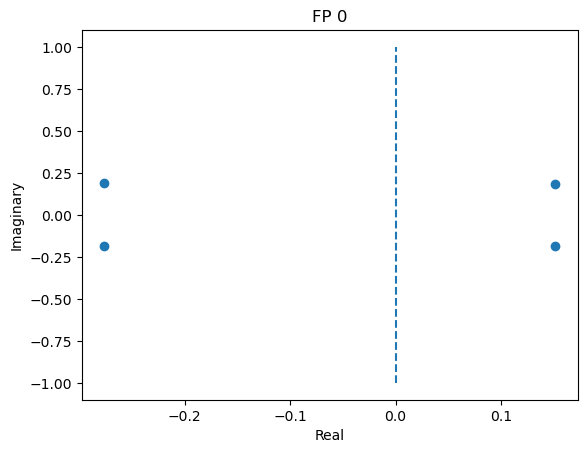

In [12]:
analyze_net(num=2, gjw=0.1, Iext=bm.asarray([0., 0.6]))

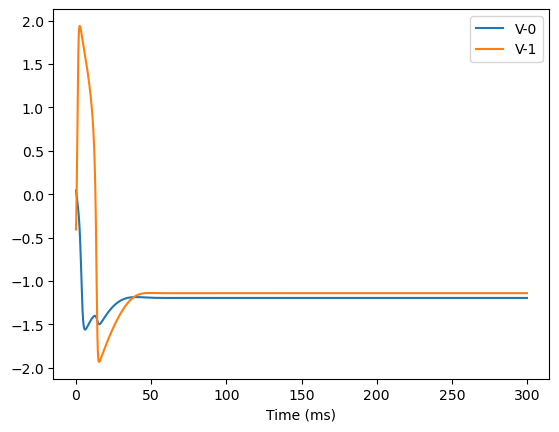

Optimizing to find fixed points:
    Batches 1-200 in 0.28 sec, Training loss 0.1000278069
    Batches 201-400 in 0.26 sec, Training loss 0.0216853047
    Batches 401-600 in 0.27 sec, Training loss 0.0129203812
    Batches 601-800 in 0.27 sec, Training loss 0.0103963392
    Batches 801-1000 in 0.26 sec, Training loss 0.0090740372
    Batches 1001-1200 in 0.26 sec, Training loss 0.0081228933
    Batches 1201-1400 in 0.27 sec, Training loss 0.0073540754
    Batches 1401-1600 in 0.26 sec, Training loss 0.0067063364
    Batches 1601-1800 in 0.27 sec, Training loss 0.0061526375
    Batches 1801-2000 in 0.27 sec, Training loss 0.0056660681
    Batches 2001-2200 in 0.29 sec, Training loss 0.0052328892
    Batches 2201-2400 in 0.26 sec, Training loss 0.0048409461
    Batches 2401-2600 in 0.27 sec, Training loss 0.0044802725
    Batches 2601-2800 in 0.27 sec, Training loss 0.0041462450
    Batches 2801-3000 in 0.26 sec, Training loss 0.0038397347
    Batches 3001-3200 in 0.26 sec, Training loss

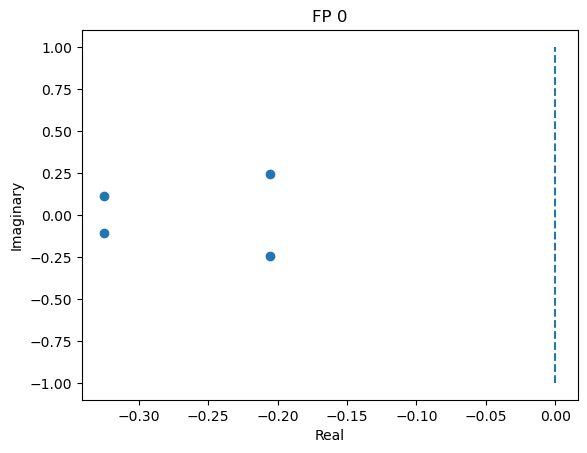

In [13]:
analyze_net(num=2, gjw=0.1, Iext=bm.asarray([0., 0.1]))

## 8D system

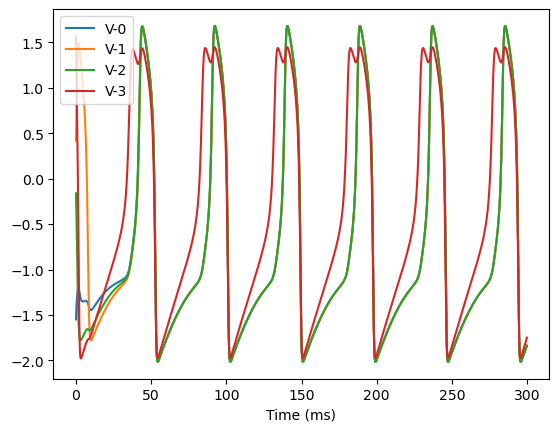

Optimizing to find fixed points:
    Batches 1-200 in 0.32 sec, Training loss 0.1248303929
    Batches 201-400 in 0.32 sec, Training loss 0.0239558379
    Batches 401-600 in 0.31 sec, Training loss 0.0135697149
    Batches 601-800 in 0.32 sec, Training loss 0.0106228349
    Batches 801-1000 in 0.32 sec, Training loss 0.0091001508
    Batches 1001-1200 in 0.32 sec, Training loss 0.0080552608
    Batches 1201-1400 in 0.32 sec, Training loss 0.0072481540
    Batches 1401-1600 in 0.33 sec, Training loss 0.0065882325
    Batches 1601-1800 in 0.32 sec, Training loss 0.0060318719
    Batches 1801-2000 in 0.31 sec, Training loss 0.0055537606
    Batches 2001-2200 in 0.32 sec, Training loss 0.0051327216
    Batches 2201-2400 in 0.34 sec, Training loss 0.0047544718
    Batches 2401-2600 in 0.32 sec, Training loss 0.0044122167
    Batches 2601-2800 in 0.38 sec, Training loss 0.0041000219
    Batches 2801-3000 in 0.47 sec, Training loss 0.0038109057
    Batches 3001-3200 in 0.33 sec, Training loss

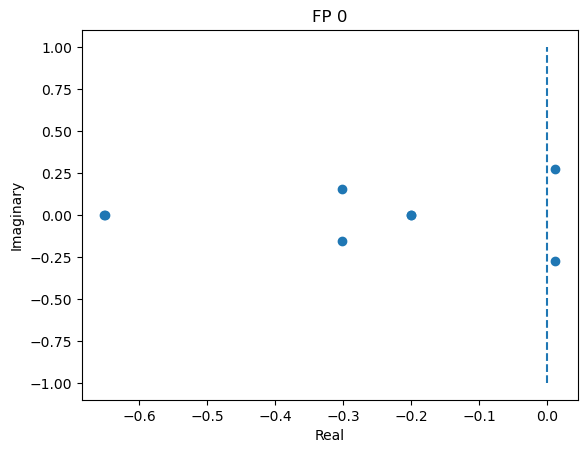

In [19]:
analyze_net(num=4, gjw=0.1, Iext=bm.asarray([0., 0., 0., 0.6]))